# EDA Workshop 1



In [22]:
import os
import pandas as pd
from sqlalchemy import create_engine, Column, Integer, String, DateTime, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import psycopg2
from psycopg2 import Error
from dotenv import load_dotenv
import matplotlib.pyplot as plt

PostgreSQL Database Connection

In [7]:
# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Configurar la cadena de conexión utilizando variables de entorno
DATABASE = os.getenv('db_name')
USER = os.getenv('db_user')
PASSWORD = os.getenv('db_password')
HOST = os.getenv('db_host')
PORT = os.getenv('db_port')

# Crear la cadena de conexión
database_url = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'

# Crear el motor de SQLAlchemy
engine = create_engine(database_url)

# Crear una sesión de SQLAlchemy
Session = sessionmaker(bind=engine)
session = Session()

# Declarar la clase base para el mapeo de ORM
Base = declarative_base()

# Definir el modelo Candidates
class Candidates(Base):
    __tablename__ = 'Candidates'
    id = Column(Integer, primary_key=True, autoincrement=True)
    FirstName = Column(String(100), nullable=False)
    LastName = Column(String(100), nullable=False)
    Email = Column(String(100), nullable=False)
    ApplicationDate = Column(DateTime, nullable=False)
    Country = Column(String(100), nullable=False)
    YOE = Column(Integer, nullable=False)
    Seniority = Column(String(100), nullable=False)
    Technology = Column(String(100), nullable=False)
    CodeChallengeScore = Column(Integer, nullable=False)
    TechnicalInterviewScore = Column(Integer, nullable=False)

# Crear todas las tablas definidas en el modelo
Base.metadata.create_all(engine)

# Leer datos desde el archivo CSV utilizando Pandas
csv_file = 'candidates.csv'
try:
    df = pd.read_csv(csv_file, sep=';', encoding='latin-1')
    print("Archivo CSV leído exitosamente con codificación latin-1")
except Exception as e:
    print("Error al leer el archivo CSV:", e)

# Renombrar las columnas del DataFrame para que coincidan con las de la tabla en la base de datos
df = df.rename(columns={
    'First Name': 'FirstName',
    'Last Name': 'LastName',
    'Application Date': 'ApplicationDate',
    'Code Challenge Score': 'CodeChallengeScore',
    'Technical Interview Score': 'TechnicalInterviewScore'
})


# Insertar los datos del DataFrame en la tabla Candidates
df.to_sql('Candidates', engine, if_exists='append', index=False)

print("Datos cargados correctamente desde el archivo CSV a la tabla en la base de datos")

C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_19132\3419755089.py:22: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Archivo CSV leído exitosamente con codificación latin-1
Datos cargados correctamente desde el archivo CSV a la tabla en la base de datos


From the database we bring the candidate table to perform its respective analysis.

In [12]:
from config import db_name, db_user, db_password, db_host, db_port  

try:
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    cursor = conn.cursor()
    print("Datos extraídos: ")
    comando = 'SELECT * FROM public."Candidates"'
    cursor.execute(comando)
    datos = cursor.fetchall()
    df = pd.DataFrame(datos, columns=[desc[0] for desc in cursor.description])
    print("DataFrame:")
    print(df.head())
except Error as e:
    print(f"Error en la conexión: {e}")
finally:
    if conn:
        conn.close()


Datos extraídos: 
DataFrame:
   id   FirstName    LastName                      Email ApplicationDate  \
0   1  Bernadette   Langworth        leonard91@yahoo.com      2021-02-26   
1   2      Camryn    Reynolds        zelda56@hotmail.com      2021-09-09   
2   3       Larue      Spinka   okey_schultz41@gmail.com      2020-04-14   
3   4        Arch      Spinka     elvera_kulas@yahoo.com      2020-10-01   
4   5       Larue  Altenwerth  minnie.gislason@gmail.com      2020-05-20   

   Country  YOE  Seniority                         Technology  \
0   Norway    2     Intern                      Data Engineer   
1   Panama   10     Intern                      Data Engineer   
2  Belarus    4  Mid-Level                     Client Success   
3  Eritrea   25    Trainee                          QA Manual   
4  Myanmar   13  Mid-Level  Social Media Community Management   

   CodeChallengeScore  TechnicalInterviewScore  
0                   3                        3  
1                   2    

In [13]:
df.isnull().sum()

id                         0
FirstName                  0
LastName                   0
Email                      0
ApplicationDate            0
Country                    0
YOE                        0
Seniority                  0
Technology                 0
CodeChallengeScore         0
TechnicalInterviewScore    0
dtype: int64

Columna Hired 

In [14]:
def hired(df):
    # Condición para determinar si está contratado
    candidate = (df["CodeChallengeScore"] >= 7) & (df["TechnicalInterviewScore"] >= 7)
    # Convertir la condición a 1 o 0
    result = candidate.astype(int)
    return result


df["Hired"] = hired(df)


print(df["Hired"])

0        0
1        0
2        1
3        0
4        1
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Hired, Length: 50000, dtype: int32


Agregamos una nueva tabla a la base de datos 

In [15]:
engine = create_engine(database_url)
df.to_sql("CandidatesHired", con=engine, if_exists="replace")

1000

Funcion por Tecnologia 

In [18]:
from tabulate import tabulate

Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()

# Definir la clase de tu tabla (reemplaza Table con el nombre de tu tabla real)
class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    Technology = Column(String)
    Hired = Column(Integer)


groupby_tech = session.query(CandidatesHired.Technology, func.count(CandidatesHired.Technology))\
    .filter(CandidatesHired.Hired == 1)\
    .group_by(CandidatesHired.Technology)\
    .order_by(func.count(CandidatesHired.Technology).desc())\
    .all()

# Convertir los resultados en una lista de listas para tabulate
table_data = [(tech, count) for tech, count in groupby_tech]

# Imprimir los resultados en forma de tabla
print(tabulate(table_data, headers=['Technology', 'Hired'], tablefmt='grid'))

+-----------------------------------------+---------+
| Technology                              |   Hired |
+=========================================+=========+
| Game Development                        |     519 |
+-----------------------------------------+---------+
| DevOps                                  |     495 |
+-----------------------------------------+---------+
| System Administration                   |     293 |
+-----------------------------------------+---------+
| Development - CMS Backend               |     284 |
+-----------------------------------------+---------+
| Database Administration                 |     282 |
+-----------------------------------------+---------+
| Adobe Experience Manager                |     282 |
+-----------------------------------------+---------+
| Client Success                          |     271 |
+-----------------------------------------+---------+
| Development - Frontend                  |     266 |
+---------------------------

C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_19132\1519811875.py:3: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Grafica 

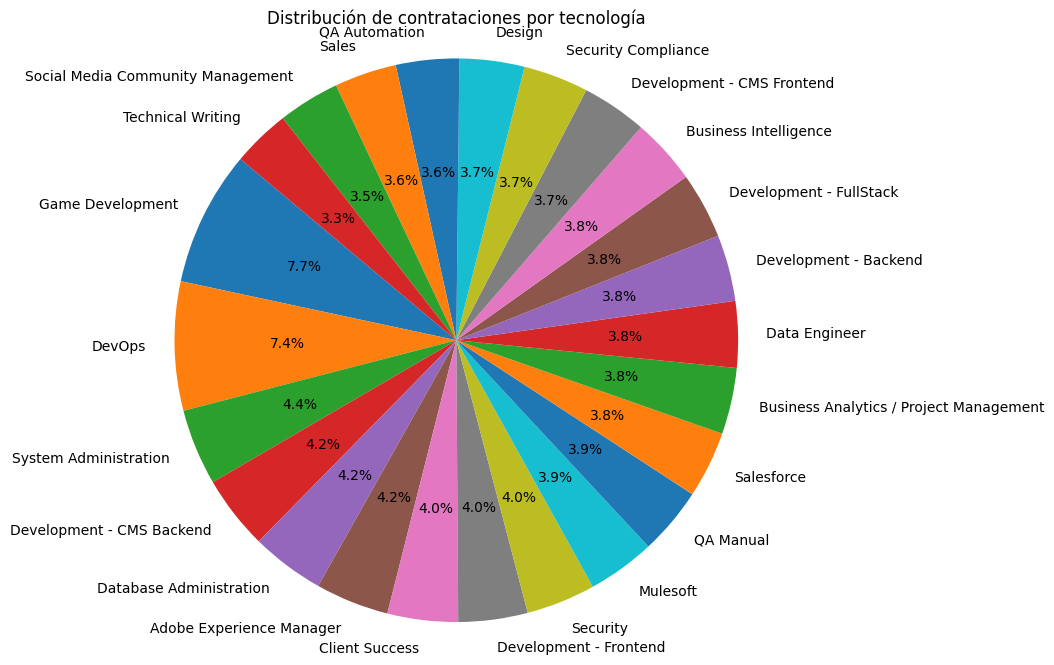

In [23]:
Technology = [row[0] for row in groupby_tech]
Hired = [row[1] for row in groupby_tech]

plt.figure(figsize=(8, 8))
plt.pie(Hired, labels=Technology, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Distribución de contrataciones por tecnología')
plt.show()

session.close()

Funciones por Año 

In [24]:
from sqlalchemy import func, extract
Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()

class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    ApplicationDate = Column()
    Hired = Column(Integer)

groupby_year_hired = session.query(
        extract('year', CandidatesHired.ApplicationDate).label('year'),
        CandidatesHired.Hired,
        func.count(CandidatesHired.id)
    )\
    .filter(CandidatesHired.Hired == 1)\
    .group_by('year', CandidatesHired.Hired)\
    .order_by('year')\
    .all()

# Imprimir los resultados
data = []

for row in groupby_year_hired:
    year, hired, count = row
    data.append((year, count))

# Presentar los datos en forma de tabla
print(tabulate(data, headers=['Año', 'Cantidad'], tablefmt='pretty'))

# Cerrar la sesión
session.close()

+------+----------+
| Año  | Cantidad |
+------+----------+
| 2018 |   1409   |
| 2019 |   1524   |
| 2020 |   1485   |
| 2021 |   1485   |
| 2022 |   795    |
+------+----------+


C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_19132\418403297.py:2: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Grafica por Año Barra Horizontal

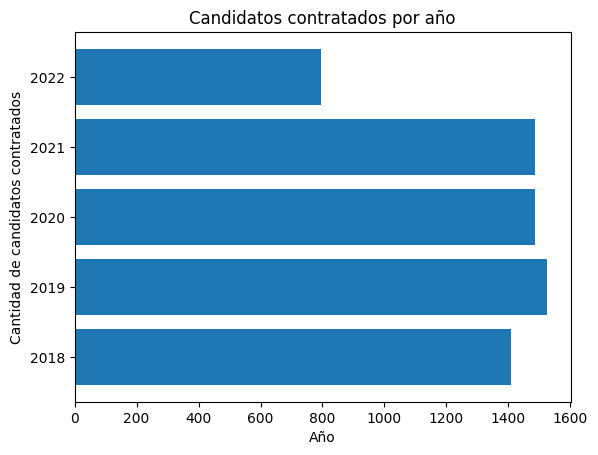

In [25]:
# Extraer los datos de la consulta
year = [row[0] for row in groupby_year_hired]
count = [row[2] for row in groupby_year_hired]

# Crear el gráfico de barras
plt.barh(year, count)
plt.xlabel('Año')
plt.ylabel('Cantidad de candidatos contratados')
plt.title('Candidatos contratados por año')
plt.show()

Funcion por Seniority

In [26]:
Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()

# Definir la clase de tu tabla (reemplaza Table con el nombre de tu tabla real)
class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    Seniority = Column(String)
    Hired = Column(Integer)


groupby_seniority = session.query(CandidatesHired.Seniority, func.count(CandidatesHired.Seniority))\
    .filter(CandidatesHired.Hired == 1)\
    .group_by(CandidatesHired.Seniority)\
    .order_by(func.count(CandidatesHired.Seniority).desc())\
    .all()

# Convertir los resultados en una lista de listas para tabulate
table_data = [(tech, count) for tech, count in groupby_seniority]

# Imprimir los resultados en forma de tabla
print(tabulate(table_data, headers=['Seniority', 'Hired'], tablefmt='grid'))

+-------------+---------+
| Seniority   |   Hired |
+=============+=========+
| Intern      |     985 |
+-------------+---------+
| Junior      |     977 |
+-------------+---------+
| Trainee     |     973 |
+-------------+---------+
| Architect   |     971 |
+-------------+---------+
| Senior      |     939 |
+-------------+---------+
| Lead        |     929 |
+-------------+---------+
| Mid-Level   |     924 |
+-------------+---------+


C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_19132\135426487.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Grafico Seniority

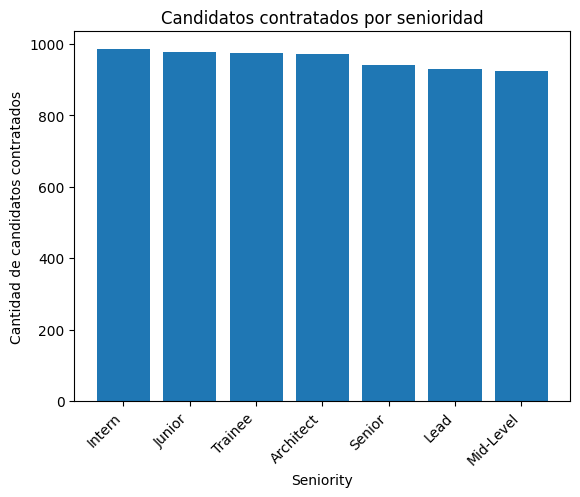

In [27]:
seniorities = [row[0] for row in groupby_seniority]
counts = [row[1] for row in groupby_seniority]

# Crear el gráfico de barras
plt.bar(seniorities, counts)
plt.xlabel('Seniority')
plt.ylabel('Cantidad de candidatos contratados')
plt.title('Candidatos contratados por senioridad')
plt.xticks(rotation=45, ha='right')
plt.show()

Funcion por Pais 

In [28]:
from sqlalchemy import func, or_

Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()

class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    ApplicationDate = Column()
    Country = Column(String)
    Hired = Column(Integer)
# Lista de países de interés
paises_interes = ['United States of America', 'Brazil', 'Colombia', 'Ecuador']

# Realizar la consulta
groupby_country_year = session.query(
        CandidatesHired.Country,
        extract('year', CandidatesHired.ApplicationDate).label('year'),
        func.count(CandidatesHired.id)
    )\
    .filter(CandidatesHired.Hired == 1)\
    .filter(CandidatesHired.Country.in_(paises_interes))\
    .group_by(CandidatesHired.Country, 'year')\
    .order_by('year')\
    .all()

data = []
for row in groupby_country_year:
    country, year, count = row
    data.append((country, year, count))

# Presentar los datos en forma de tabla
print(tabulate(data, headers=['País', 'Año', 'Candidatos contratados'], tablefmt='pretty'))

+--------------------------+------+------------------------+
|           País           | Año  | Candidatos contratados |
+--------------------------+------+------------------------+
|          Brazil          | 2018 |           9            |
|         Colombia         | 2018 |           7            |
|         Ecuador          | 2018 |           1            |
| United States of America | 2018 |           5            |
|          Brazil          | 2019 |           7            |
|         Colombia         | 2019 |           8            |
|         Ecuador          | 2019 |           3            |
| United States of America | 2019 |           3            |
|          Brazil          | 2020 |           6            |
|         Colombia         | 2020 |           8            |
|         Ecuador          | 2020 |           8            |
| United States of America | 2020 |           4            |
|          Brazil          | 2021 |           7            |
|         Colombia      

C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_19132\4207064111.py:3: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Grafico por Pais Lineas

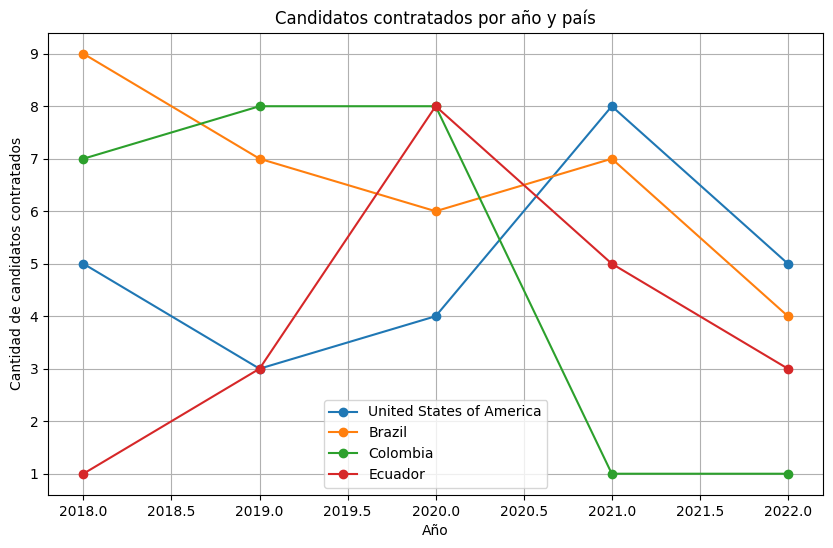

In [29]:
# Crear un diccionario para almacenar los datos por país
data_por_pais = {pais: {'years': [], 'counts': []} for pais in paises_interes}

# Procesar los resultados de la consulta
for row in groupby_country_year:
    country, year, count = row
    # Convertir el año a un entero
    year = int(year)
    data_por_pais[country]['years'].append(year)
    data_por_pais[country]['counts'].append(count)

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
for pais, data in data_por_pais.items():
    plt.plot(data['years'], data['counts'], label=pais, marker='o')

plt.xlabel('Año')
plt.ylabel('Cantidad de candidatos contratados')
plt.title('Candidatos contratados por año y país')
plt.legend()
plt.grid(True)
plt.show()
